In [39]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint

In [40]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_stateology as TpM
import b_spin_ops as su2
import c_maxent_eom as gij

In [41]:
params={}
params['Delta']=1.
params['size'],params['chain_type'] = 6,'XX'
params['h']=0;params['Jx']=.5*2*np.pi
params['g'] = .1; params['w'] = params['Omega']=np.pi; temp=1

### Laboratory frame

In [42]:
spin_ops=su2.one_body_spin_ops(args=params)
H0 = .5* params['Delta'] * sum(sigmaz for sigmaz in spin_ops['sz']) 
Hint = params['g'] * su2.Heisenberg_1D_Hamiltonian(args=params,
                                   spin_ops=spin_ops,
                                   closed_bcs=True, visualization=False)

def Vt_driving(t,args):
    return args['g']*np.cos(-args['Omega']*t)

Vt_ops =  sum(sigmax for sigmax in spin_ops['sx'])

def Vt_ext(t,args):
    return Vt_driving(t=t,args=args) * Vt_ops

H_mesolve=[H0+Hint, [Vt_ops, Vt_driving]]

### Rotating wave frame

In [43]:
H_rwa = .5*params['Delta'] * sum(sigmaz for sigmaz in spin_ops['sz']) 
H_rwa += .5*sum( np.cos(params['Omega'])*spin_ops['sx'][N] 
                    + np.sin(params['Omega'])*spin_ops['sy'][N]
                 for N in range(len(spin_ops['sz'])))
H_rwa += Hint

In [44]:
def fetch_covar_scalar_product(sigma: Qobj):
    return lambda op1, op2: 0.5 * (sigma * (op1.dag() * op2 +
                                            op2 * op1.dag())).tr()

def covar_scalar_product(op1: Qobj, op2: Qobj, sigma: Qobj):
    return .5 * (sigma * (op1.dag()*op2+op2*op1.dag())).tr()

def gram_matrix(basis: list, sp: Callable):
    size = len(basis)
    result = np.zeros([size, size], dtype=float)

    for i, op1 in enumerate(basis):
        for j, op2 in enumerate(basis):
            if j < i:
                continue
            entry = np.real(sp(op1, op2))
            if i == j:
                result[i, i] = entry
            else:
                result[i, j] = result[j, i] = entry

    return result.round(14)

def orthogonalize_basis(basis, sigma, visualization = False, reinforce_reality=False):
    if isinstance(basis, dict):
        basis = [basis[key] for key in basis]
    if isinstance(basis[0], list):
        basis = [op for op1l in basis for op in op1l]
    basis = []
    
    for i, op in enumerate(basis): 
        op_norm = np.sqrt(covar_scalar_product(op, op, sigma))
        op = op/op_norm
        alpha = np.array([covar_scalar_product(op2, op, sigma) for op2 in basis])
        if reinforce_reality:
            alpha = alpha.real
        if visualization:
            print(alpha)
        op_mod = op - sum([c*op2 for c, op2, in zip(alpha, basis)])
        op_norm = np.sqrt(covar_scalar_product(op_mod,op_mod,sigma))
        if visualization:
                print("*****************norm", op_norm)
        if op_norm > 1.e-5:
            op_mod = op_mod/(op_norm)
            basis.append(op_mod)
    return basis

def build_HierarchicalBasis(generator: Qobj, seed_operator: Qobj, depth, tol = 1e-5, verbose = False):
    assert linalg.norm(seed_operator - seed_operator.dag()) < tol, "Error: Seed operator not Hermitian"
    hierarch_basis_local = [seed_operator]
    for i in range(1, depth):
        local_op = 1j * commutator(generator, hierarch_basis_local[i-1])
        assert linalg.norm(local_op - local_op.dag()) < tol, "Error: Iterated Commutator not Hermitian"
        norm = linalg.norm(local_op)
        if norm > tol:
            pass
        else: 
            local_op = None
            if verbose:
                print("     ###. HBasis terminated at step ", i)
        hierarch_basis_local.append(local_op)
        local_op = norm = None
    return hierarch_basis_local    

def project_op(op: Qobj, orthogonal_basis: list, sp: Callable):
    return np.array([sp(op2, op) for op2 in orthogonal_basis])

def commutator(op1,op2):
    return op1*op2-op2*op1

def func_maxent(y, t, new_basis, Hamiltonian):
    basis=new_basis
    Kt_local = qutip.Qobj(sum(yi * opi for yi,opi in zip(y, basis)))
    sigmat_local = TpM.safe_expm_and_normalize(Kt_local)
    orth_basis=orthogonalize_basis(basis=basis, sigma=sigmat_local)
    hijtensor = np.array([[covar_scalar_product(op1, 
                                                -1j*(commutator(Hamiltonian, op2)), 
                                                sigmat_local) for op2 in basis]
                                                              for op1 in basis])
    dydt = hijtensor@y
    return dydt

In [45]:
# Copyright (c) 2014, Warren Weckesser
# All rights reserved.
# See the LICENSE file for license information.

import numpy as np
from scipy.integrate import odeint


# Tuple holding the major and minor versions of numpy.
_NUMPY_VERSION = tuple(int(d) for d in np.__version__.split('.')[:2])

if _NUMPY_VERSION >= (1, 7):
    _astype_kwargs = {'copy': False}
else:
    _astype_kwargs = {}


def _check_args(kwargs):
    """
    Check for arguments that are not supported with array differential
    equations.
    """
    _unsupported_odeint_args = ['col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintw for array differential equations." %
                         (bad_args[0],))


def _float64_view_of_complex128(z):
    """
    Convert z to a float64 view of a complex128 array.

    Convert z to an array that is at lead 1-d, with type np.complex128,
    and then return a np.float64 view of that array.
    """
    return np.atleast_1d(z).astype(np.complex128).view(np.float64)


def _complex_to_real_jac(jac):
    """
    Convert a complex array to a real array with doubled dimensions.

    Each element a+i*b of `jac` is expanded to the 2x2 real block:
        [[a, -b],
         [b,  a]].

    For example, the 2x2 complex matrix::

        [1+2j  3+4j]
        [5+6j  7+8j]

    becomes the real matrix::

        [1 -2  3 -4]
        [2  1  4  3]
        [5 -6  7 -8]
        [6  5  8  7]
    """
    real_jac = np.empty((2*jac.shape[0], 2*jac.shape[1]))
    real_jac[0::2, 0::2] = jac.real
    real_jac[1::2, 1::2] = jac.real
    real_jac[0::2, 1::2] = -jac.imag
    real_jac[1::2, 0::2] = jac.imag
    return real_jac


def _transform_banded_jac(bjac):
    """
    Convert a real matrix of the form (for example)

        [0 0 A B]        [0 0 0 B]
        [0 0 C D]        [0 0 A D]
        [E F G H]   to   [0 F C H]
        [I J K L]        [E J G L]
                         [I 0 K 0]

    That is, every other column is shifted up one.
    """
    # Shift every other column.
    newjac = np.zeros((bjac.shape[0] + 1, bjac.shape[1]))
    newjac[1:, ::2] = bjac[:, ::2]
    newjac[:-1, 1::2] = bjac[:, 1::2]
    return newjac


def odeintw(func, y0, t, **kwargs):
    """
    An odeint-like function for complex array-valued differential equations.

    The function `scipy.integrate.odeint` is a wrapper of the LSODA function
    for solving ordinary differential equations.  It is designed to handle
    a system of first order differential equations expressed as a vector
    function.  `odeint` does not handle equations with complex dependent
    variables, or array equations.

    `odeintw` is a wrapper of `odeint` that adds the ability to handle
    complex and array differential equations.  See the docstring of odeint
    for an explanation of its arguments.

    Unlike odeint, all arguments after the first three position arguments
    `func` (the system definition function), `y0` (the initial condition)
    and `t` (the time values) must be given as keyword arguments.

    Initial conditions
    ------------------
    The initial condition `y0` given to `odeintw` determines the type of the
    solution that is generated.  The data type and shape of the value
    returned by `func` must match those of the initial condition.

    If the solution is to be complex, the initial condition must be complex.
    To solve a complex differential equation with real initial conditions,
    give complex initial conditions with zero imaginary parts.

    Similarly, the shape of the solution of a matrix differential equation
    is determined by the shape of the initial condition.  For example, if
    the initial condition has shape (2,3), then `func` must return a numpy
    array (or something array-like) that has shape (2,3).

    Special handling of Jacobian arguments
    --------------------------------------
    The argument `Dfun` may be used with array equations.  If `shp` is the
    shape of the array, then the shape of the Jacobian array returned by
    `Dfun` must be ``shp + shp``.  For example, if the array is 2-d `F`,
        jac[m, n, i, j] holds dF[m,n]/da[i,j]

    `Dfun` may also be used with complex equations.  However, if the
    functions computed by `func` are not complex differentiable, the
    Jacobian function should not be used.  To use the Jacobian argument in
    this case, the equations should be rewritten as a system of real
    equations for the real and imaginary parts of the solution.  For
    example, the conjugation operation is not complex differentiable, so
    to use an explicit Jacobian for the complex scalar equation
        dz/dt = z.conj(),
    the equation must be written as
        dx/dt = x
        dy/dt = -y
    Then the Jacobian of the real system is [[1, 0], [0, -1]].
    If `Dfun` is not given as an argument, the system may be left as a
    complex differential equation.

    In the case of arrays with dimension 2 or more, the odeint arguments
    `col_deriv`, `ml` and `mu` can not be used.

    Complex array equations are handled, but to use `Dfun`, the same
    requirement on the complex differentiability of the components
    holds.
    """

    full_output = kwargs.get('full_output', False)
    tfirst = kwargs.get('tfirst', False)
    Dfun = kwargs.pop('Dfun', None)

    y0 = np.atleast_1d(np.asarray(y0))
    shape = y0.shape

    if y0.ndim == 1:
        func1 = func
        jacfunc1 = Dfun
    else:
        # y0 has dimension greater than 1.
        _check_args(kwargs)

        # Flatten y0, and create a wrapper for func that can be used
        # by odeint.
        y0 = y0.ravel()

        if tfirst:
            def vecfunc(t, y, *args):
                a = y.reshape(shape)
                dadt = func(t, a, *args)
                return np.asarray(dadt).ravel()
        else:
            def vecfunc(y, t, *args):
                a = y.reshape(shape)
                dadt = func(a, t, *args)
                return np.asarray(dadt).ravel()

        func1 = vecfunc

        if Dfun is not None:

            if tfirst:
                def jacfunc(t, y, *args):
                    a = y.reshape(shape)
                    jac = Dfun(t, a, *args)
                    return np.asarray(jac).reshape(y0.size, y0.size)
            else:
                def jacfunc(y, t, *args):
                    a = y.reshape(shape)
                    jac = Dfun(a, t, *args)
                    return np.asarray(jac).reshape(y0.size, y0.size)

            jacfunc1 = jacfunc
        else:
            jacfunc1 = None

    if not np.iscomplexobj(y0):
        y0 = y0.astype(np.float64, **_astype_kwargs)
        func2 = func1
        jacfunc2 = jacfunc1
    else:
        # y0 is complex.
        col_deriv = kwargs.pop('col_deriv', False)
        ml = kwargs.pop('ml', None)
        mu = kwargs.pop('mu', None)
        kwargs['ml'] = None if ml is None else 1 + 2*ml
        kwargs['mu'] = None if mu is None else 1 + 2*mu

        # Cast y0 to np.complex128.
        y0 = y0.astype(np.complex128, **_astype_kwargs)

        # realfunc is a wrapper of the user's function that can be
        # used by odeint.
        if tfirst:
            def realfunc(t, y, *args):
                z = y.view(np.complex128)
                dzdt = func1(t, z, *args)
                # func1 might return a python list, or a scalar, so convert
                # it to a float64 view of a complex128 array.
                dydt = _float64_view_of_complex128(dzdt)
                return dydt
        else:
            def realfunc(y, t, *args):
                z = y.view(np.complex128)
                dzdt = func1(z, t, *args)
                # func1 might return a python list, or a scalar, so convert
                # it to a float64 view of a complex128 array.
                dydt = _float64_view_of_complex128(dzdt)
                return dydt

        func2 = realfunc

        if jacfunc1 is not None:

            if tfirst:
                def jacfuncz(t, y, *args):
                    z = y.view(np.complex128)
                    jac = jacfunc1(t, z, *args)
                    if col_deriv:
                        # If col_deriv is True, transpose the result returned
                        # by jacfunc1, and continue as if col_deriv was False.
                        jac = jac.T
                    # Convert jac to real_jac, an array in which each complex
                    # value a+i*b in jac is expanded to the 2x2 array
                    # [[a, -b], [b, a]].
                    real_jac = _complex_to_real_jac(jac)
                    if ml is not None or mu is not None:
                        # Banded; shift every other column up one.
                        real_jac = _transform_banded_jac(real_jac)
                    return real_jac
            else:
                def jacfuncz(y, t, *args):
                    z = y.view(np.complex128)
                    jac = jacfunc1(z, t, *args)
                    if col_deriv:
                        # If col_deriv is True, transpose the result returned
                        # by jacfunc1, and continue as if col_deriv was False.
                        jac = jac.T
                    # Convert jac to real_jac, an array in which each complex
                    # value  a+i*b in jac is expanded to the 2x2 array
                    # [[a, -b], [b, a]].
                    real_jac = _complex_to_real_jac(jac)
                    if ml is not None or mu is not None:
                        # Banded; shift every other column up one.
                        real_jac = _transform_banded_jac(real_jac)
                    return real_jac

            jacfunc2 = jacfuncz
        else:
            jacfunc2 = None

    # Call scipy.integrate.odeint with our wrapper.
    result = odeint(func2, y0.view(np.float64), t, Dfun=jacfunc2, **kwargs)

    if full_output:
        sol, infodict = result
    else:
        sol = result

    if np.iscomplexobj(y0):
        # Restore the complex view.
        sol = sol.view(np.complex128)

    # Restore the shape.
    sol = sol.reshape(-1, *shape)

    if full_output:
        result = (sol, infodict)
    else:
        result = sol
    return result

In [46]:
def multiple_Max_Ent_evs(HB_depths: list, init_config: list):
    
    multiple_depths_evs = {}
    for hb_depth in HB_depths:
        local_result = max_ent_ev(depth=hb_depth, init_config=init_config)
            
        multiple_depths_evs["ell=" + str(hbdepth)]=local_result
        local_result=None
    return multiple_depths_evs

def max_ent_ev(t: np.array, Hamiltonian: Qobj, basis0: list, depth: int, init_config: dict):
     
    hierarchical_basis=build_HierarchicalBasis(generator=Hamiltonian,
                                               seed_operator=basis0[-1],
                                               depth=depth)
    

    new_basis=basis0+hierarchical_basis
    init_config['phi0']=init_config['phi0']+[.0 for i in range(0,depth+1)]
    assert len(new_basis)==len(init_config['phi0']), "Dimension mismatch"
    phit = odeintw(func=func_maxent, y0=init_config['phi0'], t=t, args=(new_basis,Hamiltonian))
    return phit


In [47]:
depth=2; ts=np.linspace(0,2,100),
magnetization=sum(sz for sz in spin_ops['sz'])
basis0=[spin_ops['idop'], H_rwa, magnetization]
phi0=[0, .5, .2]
K0 = -sum(phia * opa for phia,opa in zip(phi0, basis0))
sigma0=TpM.safe_expm_and_normalize(K0)
phi0[0]=np.log(sigma0.tr())
K0 = -sum(phia * opa for phia,opa in zip(phi0, basis0))
sigma0=TpM.safe_expm_and_normalize(K0)
basis0+=[K0]

init_config={}
init_config['phi0']=phi0

In [48]:
res=max_ent_ev(t=np.linspace(0,2,100), 
               Hamiltonian=H_rwa,
               basis0=basis0,
               depth=depth, 
               init_config=init_config
               )

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

#### Solving the Max-Ent Equation of motion

In [53]:
def projections(H,K0,basis0,timespan,args):
    print("**** Starting Simulation", datetime.now())
    results={}; results['covar_Kt']=[]; results['exact_Kt']=[];results['covar_sigmat']=[];results['exact_rhot']=[]
    res_exact = qutip.mesolve(H=H,
                              tlist=timespan,
                              rho0=K0,
                              args=args)
    rhot = [TpM.safe_expm_and_normalize(Kt) for Kt in res_exact.states]
    covar_sp=[fetch_covar_scalar_product(rho_at_timet) for rho_at_timet in rhot]
    timespan_prime=list(timespan)
    for t in timespan:
        ti = timespan_prime.index(t)
        if ti%5==0:
            print("-----Processing step",ti,"at time",datetime.now)
        orth_basis=orthogonalize_basis(basis=basis0,sp=covar_sp[ti],idop=basis0[0])
        phis_covar = project_op(res_exact.states[ti], orth_basis, covar_sp[ti])
        Kp_covar=sum(phi*op for phi,op in zip(phis_covar, orth_basis))
        sigma_covar=TpM.safe_expm_and_normalize(Kp_covar)
        results['covar_Kt'].append(Kp_covar)
        results['covar_sigmat'].append(sigma_covar)
    results['exact_Kt']=res_exact.states; results['exact_rhot']=rhot
    return results

In [54]:
def orthogonalize_basis(basis: list, sp: Callable, idop: Qobj = None):
    if idop:
        idnorm_sq = sp(idop, idop)
        id_comp = [sp(idop, op) / idnorm_sq for op in basis]
        basis = ([idop * idnorm_sq**-0.5] +
                 [op - la for la, op in zip(id_comp, basis)])

    gs = gram_matrix(basis, sp)
    evals, evecs = np.linalg.eigh(gs)
    evecs = [vec / np.linalg.norm(vec) for vec in evecs.transpose()]
    return [
        p ** (-0.5) * sum(c * op for c, op in zip(w, basis))
        for p, w in zip(evals, evecs)
        if p > 0.00001
    ]

In [73]:
HBB0=[spin_ops['idop'], H0]
phi0=[.0, -5.]; beta=1/temp
K0=-sum(phi*op for phi,op in zip(phi0, HBB0))
sigma0=TpM.safe_expm_and_normalize(K0)
phi0[0]=np.log(sigma0.tr())
K0=-sum(phi*op for phi,op in zip(phi0, HBB0))
sigma0=TpM.safe_expm_and_normalize(K0)

HBB0+=[H_rwa]
timespans=np.linspace(0,5,100)

In [74]:
covar_and_exact_Proj_ell0s=projections(H=H_rwa,K0=K0_eff,basis0=HBB0_j3,timespan=timespans,args=params)

**** Starting Simulation 2024-02-29 15:11:31.161194
-----Processing step 0 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 5 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 10 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 15 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 20 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 25 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 30 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 35 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 40 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 45 at time <built-in method now of type object at 0x00007FFB2D6AB650>
-----Processing step 50 at time <built-i

In [75]:
exact_Kt=covar_and_exact_Proj_ell0s['exact_Kt']
exact_rhot=covar_and_exact_Proj_ell0s['exact_rhot']
covar_Kt=covar_and_exact_Proj_ell0s['covar_Kt']
covar_sigmat=covar_and_exact_Proj_ell0s['covar_sigmat']

matrix_norm_states=[np.linalg.norm(rhoti-sigmati) for rhoti, sigmati in zip(exact_rhot,covar_sigmat)]
matrix_norm_ks=[np.linalg.norm(ex_kti-cov_kti) for ex_kti, cov_kti in zip(exact_Kt,covar_Kt)]

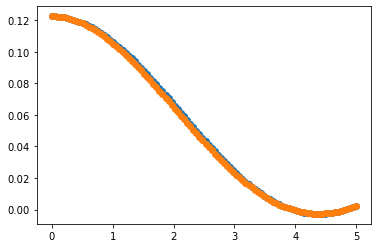

In [76]:
expectation_values={}
observables=[spin_ops['sz'][2]]
for qop in observables:
    expectation_values['exact']=[(rhoti*qop).tr() for rhoti in exact_rhot]
    expectation_values['covar']=[(sigmati*qop).tr() for sigmati in covar_sigmat]
    
plt.scatter(timespans, expectation_values['exact'])
plt.scatter(timespans, expectation_values['covar'])

In [126]:
def commutator(op1,op2):
    return op1*op2-op2*op1

In [127]:
hierarchical_basis=HBB0_j3
T=2*np.pi/params['Omega']
td_iterated_commutator=[commutator(H0+Hint+Vt_tdcoeff(ti, params),HBB0_j3[-1]) for ti in np.linspace(0,T,30)]
avg_itt_comm=1/T * sum(c_ell_ti for c_ell_ti in td_iterated_commutator)
hierarchical_basis.append(qutip.Qobj(avg_itt_comm))

In [128]:
phi0 = [.5,.5,0]; beta=1/temp

covar_and_exact_Proj_ell1s=projections(H=H,K0=K0_eff,basis0=hierarchical_basis,timespan=timespans,args=params)
exact_Kt_ell1=covar_and_exact_Proj_ell1s['exact_Kt']
exact_rhot_ell1=covar_and_exact_Proj_ell1s['exact_rhot']
covar_Kt_ell1=covar_and_exact_Proj_ell1s['covar_Kt']
covar_sigmat_ell1=covar_and_exact_Proj_ell1s['covar_sigmat']

**** Starting Simulation 2024-02-06 18:06:37.407881
-----Processing step 0 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 5 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 10 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 15 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 20 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 25 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 30 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 35 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 40 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 45 at time <built-in method now of type object at 0x00007FFB611EB650>
-----Processing step 50 at time <built-i

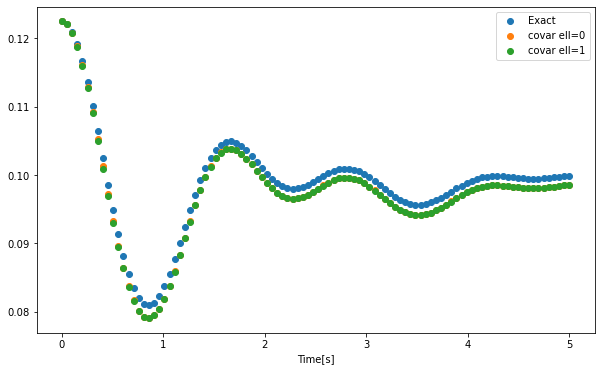

In [129]:
expectation_values_ELL1={}
observables=[spin_ops['sz'][2]]
for qop in observables:
    expectation_values_ELL1['exact']=[(rhoti*qop).tr() for rhoti in exact_rhot_ell1]
    expectation_values_ELL1['covar']=[(sigmati*qop).tr() for sigmati in covar_sigmat_ell1]

    
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.scatter(timespans, expectation_values_ELL1['exact'], label='Exact')
plt.scatter(timespans, expectation_values['covar'], label='covar ell=0')
plt.scatter(timespans, expectation_values_ELL1['covar'], label='covar ell=1')
ax0.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

In [31]:
# importing required module
import csv
 
# opening the file
with open("student_results.csv", "w", newline="") as f:
    # creating the writer
    writer = csv.writer(f)
    # using writerow to write individual record one by one
    writer.writerow(["Name", "English", "Math", "Science", "Social Science"])
    writer.writerow(["Varun", "91", "90", "74", "80"])
    writer.writerow(["Rahul", "89", "94", "81", "86"])
    writer.writerow(["Kabir", "80", "93", "88", "82"])
    writer.writerow(["Suman", "80", "75", "98", "85"])